# Quantization in Depth

Resource: https://www.deeplearning.ai/short-courses/quantization-in-depth/

## Linear quantization

In [1]:
import torch

### Quantization

In [4]:
def linear_q_with_scale_and_zero_point(
    tensor,
    scale,
    zero_point,
    dtype=torch.int8,
):
    scaled_and_shifted_tensor = tensor / scale + zero_point
    
    rounded_tensor = torch.round(scaled_and_shifted_tensor)
    
    q_min = torch.iinfo(dtype).min
    q_max = torch.iinfo(dtype).max
    
    q_tensor = rounded_tensor.clamp(q_min, q_max).to(dtype)
    
    return q_tensor

In [9]:
test_tensor = torch.tensor(
    [[191.6, -13.6, 728.6],
     [92.14, 295.5, -184],
     [0, 684.6, 245.5]]
)

In [10]:
scale = 3.5
zero_point = -70

In [11]:
quantized_tensor = linear_q_with_scale_and_zero_point(
    test_tensor,
    scale, 
    zero_point,
)

In [12]:
quantized_tensor

tensor([[ -15,  -74,  127],
        [ -44,   14, -123],
        [ -70,  126,    0]], dtype=torch.int8)

### Dequantization

In [13]:
dequantized_tensor = scale * (quantized_tensor.float() - zero_point)

In [14]:
dequantized_tensor

tensor([[ 192.5000,  -14.0000,  689.5000],
        [  91.0000,  294.0000, -185.5000],
        [   0.0000,  686.0000,  245.0000]])

In [15]:
scale * (quantized_tensor - zero_point)

tensor([[ 192.5000,  -14.0000, -206.5000],
        [  91.0000,  294.0000, -185.5000],
        [   0.0000, -210.0000,  245.0000]])

In [16]:
def linear_dequantization(
    quantized_tensor,
    scale,
    zero_point
):
    return scale * (quantized_tensor.float() - zero_point)

In [17]:
dequantized_tensor = linear_dequantization(quantized_tensor, scale, zero_point)

In [18]:
dequantized_tensor

tensor([[ 192.5000,  -14.0000,  689.5000],
        [  91.0000,  294.0000, -185.5000],
        [   0.0000,  686.0000,  245.0000]])

### Quantization error

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

def plot_matrix(tensor, ax, title, vmin=0, vmax=1, cmap=None):
    """
    Plot a heatmap of tensors using seaborn
    """
    sns.heatmap(tensor.cpu().numpy(), ax=ax, vmin=vmin, vmax=vmax, cmap=cmap, annot=True, fmt=".2f", cbar=False)
    ax.set_title(title)
    ax.set_yticklabels([])
    ax.set_xticklabels([])


def plot_quantization_errors(original_tensor, quantized_tensor, dequantized_tensor, dtype = torch.int8, n_bits = 8):
    """
    A method that plots 4 matrices, the original tensor, the quantized tensor
    the de-quantized tensor and the error tensor.
    """
    # Get a figure of 4 plots
    fig, axes = plt.subplots(1, 4, figsize=(15, 4))

    # Plot the first matrix
    plot_matrix(original_tensor, axes[0], 'Original Tensor', cmap=ListedColormap(['white']))

    # Get the quantization range and plot the quantized tensor
    q_min, q_max = torch.iinfo(dtype).min, torch.iinfo(dtype).max
    plot_matrix(quantized_tensor, axes[1], f'{n_bits}-bit Linear Quantized Tensor', vmin=q_min, vmax=q_max, cmap='coolwarm')

    # Plot the de-quantized tensors
    plot_matrix(dequantized_tensor, axes[2], 'Dequantized Tensor', cmap='coolwarm')

    # Get the quantization errors
    q_error_tensor = abs(original_tensor - dequantized_tensor)
    plot_matrix(q_error_tensor, axes[3], 'Quantization Error Tensor', cmap=ListedColormap(['white']))

    fig.tight_layout()
    plt.show()

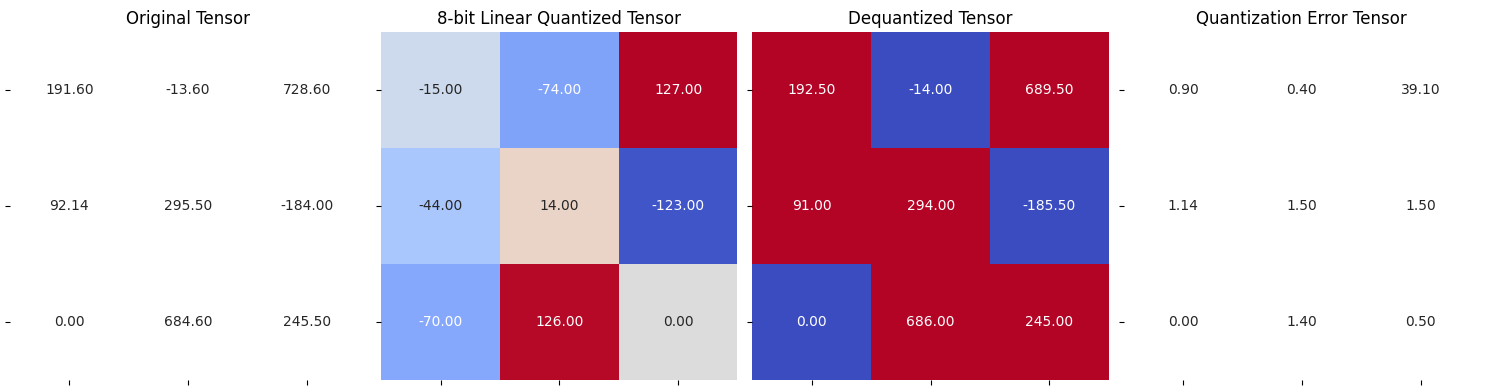

In [21]:
plot_quantization_errors(test_tensor, quantized_tensor, dequantized_tensor)

In [22]:
dequantized_tensor - test_tensor

tensor([[  0.9000,  -0.4000, -39.1000],
        [ -1.1400,  -1.5000,  -1.5000],
        [  0.0000,   1.4000,  -0.5000]])

In [23]:
(dequantized_tensor - test_tensor).square()

tensor([[8.0999e-01, 1.6000e-01, 1.5288e+03],
        [1.2996e+00, 2.2500e+00, 2.2500e+00],
        [0.0000e+00, 1.9601e+00, 2.5000e-01]])

In [24]:
(dequantized_tensor - test_tensor).square().mean()

tensor(170.8653)

## Asymetric linear quantization

### Finding scale and zero point

In [29]:
test_tensor

tensor([[ 191.6000,  -13.6000,  728.6000],
        [  92.1400,  295.5000, -184.0000],
        [   0.0000,  684.6000,  245.5000]])

In [25]:
q_min = torch.iinfo(torch.int8).min
q_max = torch.iinfo(torch.int8).max

In [27]:
q_min, q_max

(-128, 127)

In [33]:
r_min = test_tensor.min().item()
r_max = test_tensor.max().item()

In [34]:
r_min, r_max

(-184.0, 728.5999755859375)

In [35]:
scale = (r_max-r_min)/(q_max-q_min)

In [36]:
scale

3.578823433670343

In [37]:
zero_point = q_min - (r_min/scale)

In [38]:
zero_point

-76.58645490333825

In [39]:
zero_point = int(round(zero_point))

In [40]:
zero_point

-77

In [ ]:
def get_q_scale_and_zer_point(tensor, dtype=torch.int8):
    q_min, q_max = torch.iinfo(dtype).min, torch.iinfo(dtype).max
    
    r_min, r_max = tensor.min().item(), tensor.max().item()
    
    scale = (r_max-r_min) / (q_max-q_min)
    
    zero_point = q_min - (r_min/scale)
    
    if zero_point < q_min:
        zero_point = q_min
    elif zero_point > q_max:
        zero_point = q_max
    else:
        zero_point = int(round(zero_point))
    
    return scale, zero_point

In [43]:
new_scale, new_zero_point = get_q_scale_and_zer_point(test_tensor)

In [45]:
new_scale, new_zero_point

(3.578823433670343, -77)

In [46]:
quantized_tensor = linear_q_with_scale_and_zero_point(
    test_tensor,
    new_scale,
    new_zero_point
)

In [47]:
quantized_tensor

tensor([[ -23,  -81,  127],
        [ -51,    6, -128],
        [ -77,  114,   -8]], dtype=torch.int8)

In [48]:
dequantized_tensor = linear_dequantization(
    quantized_tensor,
    new_scale,
    new_zero_point
)

In [49]:
dequantized_tensor

tensor([[ 193.2565,  -14.3153,  730.0800],
        [  93.0494,  297.0423, -182.5200],
        [   0.0000,  683.5552,  246.9388]])

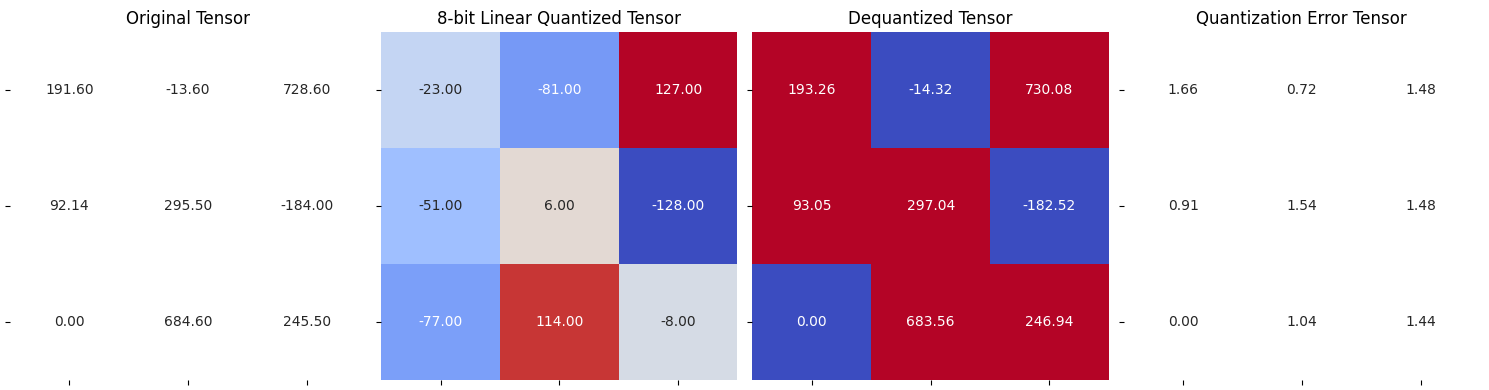

In [51]:
plot_quantization_errors(
    test_tensor,
    quantized_tensor,
    dequantized_tensor,
)

In [52]:
(dequantized_tensor-test_tensor).square().mean()

tensor(1.5560)

### Quantization and dequantization

In [53]:
def linear_quantization(
    tensor, dtype=torch.int8
):
    scale, zero_point = get_q_scale_and_zer_point(tensor, dtype)
    quantized_tensor = linear_q_with_scale_and_zero_point(tensor, scale, zero_point, dtype)
    return quantized_tensor, scale, zero_point

In [54]:
r_tensor = torch.randn((4,4 ))

In [55]:
r_tensor

tensor([[ 0.0591, -0.6031,  0.7890,  1.0494],
        [-0.5955,  0.0626, -1.5275,  0.6560],
        [-0.5713, -0.0281,  0.7846,  0.1310],
        [ 0.6143, -1.1580,  1.2214,  0.7926]])

In [56]:
quantized_tensor, scale, zero_point = linear_quantization(r_tensor)

In [57]:
quantized_tensor, scale, zero_point

(tensor([[  19,  -42,   87,  111],
         [ -41,   20, -128,   75],
         [ -39,   11,   87,   26],
         [  71,  -93,  127,   88]], dtype=torch.int8),
 0.010780104468850528,
 14)

In [58]:
dequantized_tensor = linear_dequantization(quantized_tensor, scale, zero_point)

In [59]:
dequantized_tensor

tensor([[ 0.0539, -0.6037,  0.7869,  1.0457],
        [-0.5929,  0.0647, -1.5308,  0.6576],
        [-0.5713, -0.0323,  0.7869,  0.1294],
        [ 0.6145, -1.1535,  1.2182,  0.7977]])

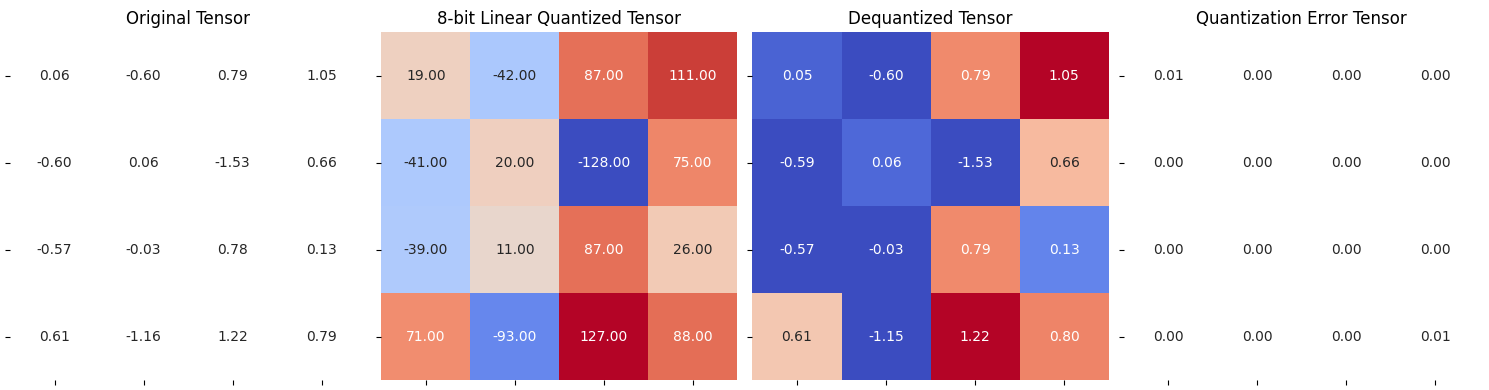

In [60]:
plot_quantization_errors(
    r_tensor,
    quantized_tensor,
    dequantized_tensor,
)

In [61]:
(dequantized_tensor-r_tensor).square().mean()

tensor(9.5786e-06)

## Symmetric linear quantization

In [62]:
def get_q_scale_symmetric(tensor, dtype=torch.int8):
    r_max = tensor.abs().max().item()
    q_max = torch.iinfo(dtype).max
    
    return r_max / q_max

In [63]:
test_tensor = torch.rand((4, 4))

In [71]:
test_tensor

tensor([[0.3630, 0.6925, 0.3240, 0.5604],
        [0.7636, 0.8003, 0.0295, 0.3944],
        [0.6491, 0.5138, 0.0174, 0.9635],
        [0.6562, 0.1744, 0.0629, 0.3370]])

In [ ]:
get_q_scale_symmetric(test_tensor)

0.007586806777894028

In [65]:
def linear_q_symmetric(tensor, dtype=torch.int8):
    scale = get_q_scale_symmetric(tensor)
    quantized_tensor = linear_q_with_scale_and_zero_point(
        test_tensor,
        scale=scale,
        zero_point=0,
        dtype=dtype
    )
    
    return quantized_tensor, scale

In [66]:
quantized_tensor, scale = linear_q_symmetric(test_tensor)

In [67]:
quantized_tensor, scale

(tensor([[ 48,  91,  43,  74],
         [101, 105,   4,  52],
         [ 86,  68,   2, 127],
         [ 86,  23,   8,  44]], dtype=torch.int8),
 0.007586806777894028)

In [68]:
dequantized_tensor = linear_dequantization(quantized_tensor, scale, 0)

In [70]:
dequantized_tensor

tensor([[0.3642, 0.6904, 0.3262, 0.5614],
        [0.7663, 0.7966, 0.0303, 0.3945],
        [0.6525, 0.5159, 0.0152, 0.9635],
        [0.6525, 0.1745, 0.0607, 0.3338]])

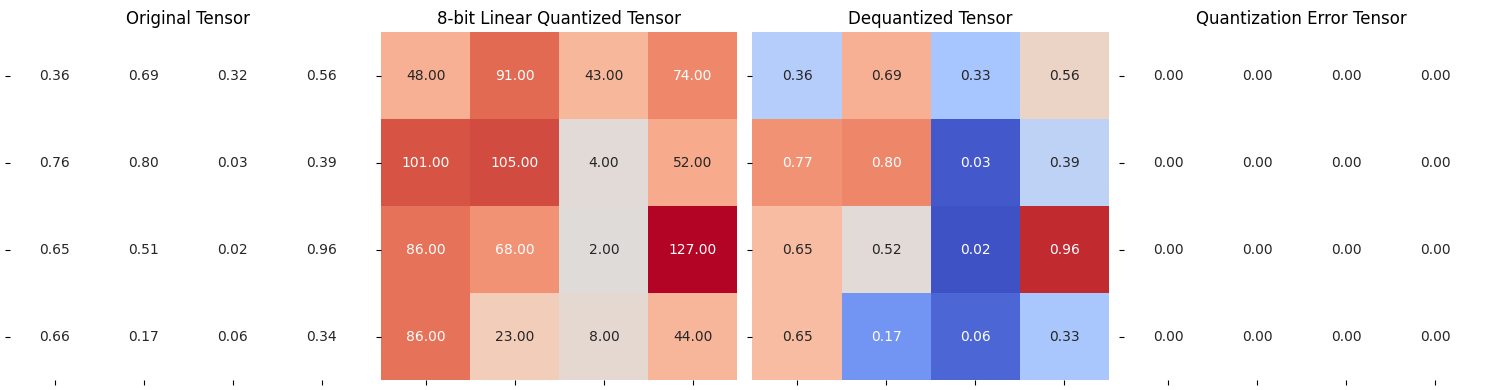

In [69]:
plot_quantization_errors(
    test_tensor,
    quantized_tensor,
    dequantized_tensor
)

In [73]:
(dequantized_tensor - test_tensor).mean().square()

tensor(4.5812e-08)